# Classifying Lyrics with LSTM Networks

In [0]:
import pandas as pd
import numpy as np
#keras imports
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.layers import LSTM,CuDNNLSTM
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf
from keras.optimizers import RMSprop
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import np_utils
#sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import pickle
#import seaborn
device_name = tf.test.gpu_device_name()
#matplotlib
import matplotlib.pyplot as plt
#misc
import itertools

To access files on Colab, you can import data directly to your google drive account and access it from there

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

We used the Keras' CuDNN LSTM implementation. In order to use this, you need to use a GPU. Change your runtime by adding a GPU as a hardware accelarator on Colab.

In [77]:
device_name

'/device:GPU:0'

### Visualizing our data
Source: Kaggle https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics


In [78]:
file_path = 'PATH_TO_DATA/lyrics.pkl'
df = pd.read_pickle(file_path, compression='gzip')
#drop nulls
df.dropna(inplace=True)
df.head()


,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


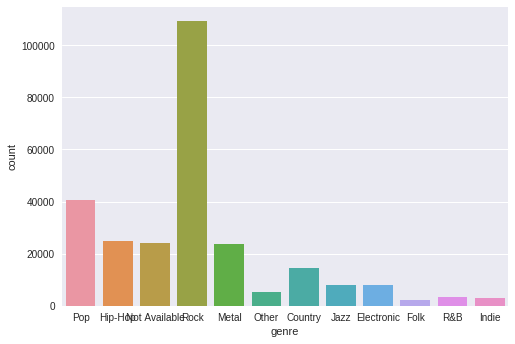

In [17]:
sns.countplot(df.genre)

### To reduce error due to unequal genre data, we chose to classify between four genres instead of the original 12

In [0]:
genres = ['Pop', 'Indie', 'Jazz', 'Rock']
df = df[(df.genre == 'Pop') | (df.genre == 'Hip-Hop') | (df.genre == 'Metal') | (df.genre == 'Rock')]
pop = df.loc[df['genre']=='Pop'].head(2000)
hiphop = df.loc[df['genre']=='Hip-Hop'].head(2000)
rock = df.loc[df['genre']=='Rock'].head(2000)
metal = df.loc[df['genre']=='Metal'].head(2000)

8000


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


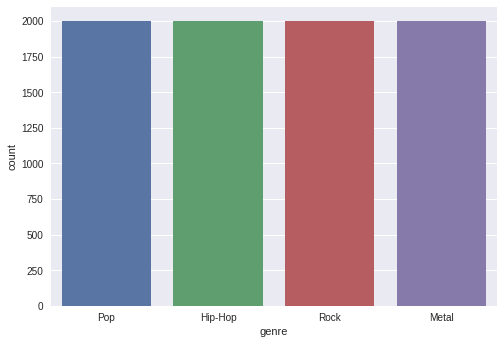

In [82]:
#really lazy way od doing this
output = pop.append(hiphop)
output = output.append(rock)
output = output.append(metal)
output.reset_index(drop=True, inplace=True)
print(len(output))
df = output
df.reset_index(drop=True, inplace=True)
sns.countplot(df.genre)

## Data Preprocessing


1.   Lowercase all the text, remove new lines, and convert each song into a list of words
2.   Preprocess_df tokenizes these lists and creates sequences out of them with their lengths being the length of the longest song in our data
3.   One-hot encode our target variables
4.   Create our test/train data


In [0]:
 df['lyrics'] = df['lyrics'].apply(lambda x: str(x).lower().replace('\n', " ").split(' '))

In [0]:
#preprocess the df without word embeddings.
def preprocess_df(df, save_pickle = False):
        #split and lower all values 
        print('lowering vals and converting songs to lists...')
        #df['lyrics'] = df['lyrics'].apply(lambda x: str(x).lower().replace('\n', " ").split(' '))
        #find max value in lyrics
        print('finding max length of a song...')
        max_len = 0
        index = 0
        for i in range(len(df['lyrics'])):
          lyric = df.lyrics.iloc[i]
          #max_len = max(len(lyric), max_len)
          if max_len < len(lyric):
            max_len = len(lyric)
            index = i
        print('max_len',max_len)
        print('index', i)
        max_words = 10000
        print('Tokenizing...')
        #tok = Tokenizer(num_words=max_words)
        tok = Tokenizer(num_words=max_len)
        tok.fit_on_texts(df.lyrics)
        sequences = tok.texts_to_sequences(df.lyrics)
        sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
        #check to make sure length is 8196 
        #reshape to 3-dimensional because thats how Dynamic RNNs like it.
        #90928 = 28408 * 4 (num of each type of song)
        print('reshaping output')
        sequences_matrix = sequences_matrix.reshape(len(df), max_len,1)
        #sequences_matrix = sequences_matrix.reshape(len(df), max_len)

        print(sequences_matrix.shape)
        if save_pickle:
                print('writing to file...')
                temp = sequences_matrix.reshape(len(df), 1238)
                with open('lyrics_clean.txt', 'w') as outfile:
                        np.savetxt(outfile, temp)
                print('saved.')
        return sequences_matrix

In [30]:
sequences_matrix = preprocess_df(df)

lowering vals and converting songs to lists...
finding max length of a song...
max_len 8196
index 7999
Tokenizing...
reshaping output
(8000, 8196, 1)


Confirm our longest song's length

In [31]:
df.lyrics.map(len).max()
df['TEST'] = df.lyrics.apply(lambda x: len(x))
df.TEST.idxmax()

df.iloc[3024]

index                                                 18869
song                                           rap-monument
year                                                   2014
artist                                     flatbush-zombies
genre                                          [0, 1, 0, 0]
lyrics    [raprock, lit, pop, news, country, r&b;, histo...
TEST                                                   8196
Name: 3024, dtype: object

One-hot encode targets

In [0]:
#lazy way to one-hot encode
one_hot = {'Pop':[1,0,0,0], 'Hip-Hop':[0,1,0,0], 'Metal': [0,0,1,0], 'Rock':[0,0,0,1]}

df['genre'] = df['genre'].apply(lambda x: one_hot[x])

In [0]:
targets = np.matrix(df['genre'].tolist())

Create an 80/20 test-train split

In [0]:

from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(sequences_matrix,targets,test_size=0.2)


## Building Our Models
### We tested 4 different types of models


1.   1 Layer LSTM Model
2.   1 Layer LSTM Model W/Dropout
3.   2 Layer LSTM Model
4.   1 Layer LSTM Model W/Word Embeddings



## 1 Layer LSTM Model

In [0]:
from keras.layers import CuDNNLSTM, Flatten
from keras.layers import Dropout, Embedding
model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(sequences_matrix[0].shape)))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_12 (CuDNNLSTM)    (None, 128)               67072     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_9 (Activation)    (None, 4)                 0         
Total params: 67,588
Trainable params: 67,588
Non-trainable params: 0
_________________________________________________________________
None


## 1 Layer LSTM Model W/Dropout

In [43]:
from keras.layers import CuDNNLSTM, Flatten
from keras.layers import Dropout, Embedding
model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(sequences_matrix[0].shape)))
model.add(Dropout(.2))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())
optimizer = RMSprop(lr=0.001)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 128)               67072     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 67,588
Trainable params: 67,588
Non-trainable params: 0
_________________________________________________________________
None


## 2 Layer LSTM Model 

In [0]:
from keras.layers import CuDNNLSTM, Flatten
from keras.layers import Dropout, Embedding
model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(sequences_matrix[0].shape), return_sequences=True))
model.add(CuDNNLSTM(64))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_10 (CuDNNLSTM)    (None, 8196, 128)         67072     
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 64)                49664     
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260       
_________________________________________________________________
activation_8 (Activation)    (None, 4)                 0         
Total params: 116,996
Trainable params: 116,996
Non-trainable params: 0
_________________________________________________________________
None


## 1 Layer LSTM Model W/Embedding Layer
- Note: sequence matrix must be reshaped to run this model

In [40]:
from keras.layers import CuDNNLSTM, Flatten
from keras.layers import Dropout, Embedding, LSTM
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=50, input_length=8196))
#model.add(Flatten())
#model.add(CuDNNLSTM(128, input_shape=(sequences_matrix[0].shape)))
model.add(CuDNNLSTM(128))
model.add(Dropout(.2))
model.add(Dense(4))
model.add(Activation('softmax'))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8196, 50)          50000     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               92160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 142,676
Trainable params: 142,676
Non-trainable params: 0
_______________

## Train Model
1. We chose RMSProp as our optimizer as computing squared gradients has proven to decrease the impact of the vanishing gradient
2. We chose Categorical Crossentropy as our loss function as it is the most commonly used function in multi-class classification problems and works well w/one-hot encoded target variables

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

optimizer = RMSprop(lr=0.001)

filepath="drive/My Drive/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
mc = ModelCheckpoint('filepath', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=10)

#note: using rmsprop instead of adam significantly increased accuracy.
#note: using cudnnlstm drastically increased training speed.
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=100, batch_size=128, shuffle=True, callbacks=[tensorboard,mc])

model.save('full_word_classifier_1D_LSTM.h5')
print('moved to drive.')

In [0]:
model.load_weights('PATH_TO_SAVE/full_word_classifier_LSTM_dropout.h5')

In [0]:
model.evaluate(X_train, Y_train)

6400/6400 [==============================] - 65s 10ms/step


[0.7697302666306496, 0.71640625]

## Testing 1 Layer LSTM W/Dropout (Best Model)

#### Predict genre for a particular song

In [0]:
song = """I knew you were
You were gonna come to me
And here you are
But you better choose carefully
'Cause I’m capable of anything
Of anything and everything
Make me your Aphrodite
Make me your one and only
But don’t make me your enemy, your enemy, your enemy
So you wanna play with magic
Boy, you should know whatcha falling for
Baby do you dare to do this
'Cause I’m coming atcha like a dark horse
Are you ready for, ready for
A perfect storm, a perfect storm
'Cause once you’re mine, once you’re mine
There’s no going back
Mark my words
This love will make you levitate
Like a bird
Like a bird without a cage
But down to earth
If you choose to walk away, don’t walk away
It’s in the palm of your hand now baby
It’s a yes or no, no maybe
So just be sure before you give it up to me
Up to me, give it up to me
So you wanna play with magic
Boy, you should know whatcha falling for
Baby do you dare to do this
'Cause I’m coming atcha like a dark horse
Are you ready for, ready for
A perfect storm, a perfect storm
'Cause once you’re mine, once you’re mine
There’s no going back
She’s a beast
I call her Karma
She eat your heart out
Like Jeffrey Dahmer
Be careful
Try not to lead her on
Shawty’s heart was on steroids
'Cause her love was so strong
You may fall in love
When you meet her
If you get the chance you better keep her
She swears by it but if you break her heart
She turn cold as a freezer
That fairy tale ending with a knight in shining armor
She can be my Sleeping Beauty
I’m gon’ put her in a coma
Woo! Damn I think I love her
Shawty so bad
I’m sprung and I don’t care
She got me like a roller coaster
Turn the bedroom into a fair
Her love is like a drug
I was tryna hit it and quit it
But lil’ mama so dope
I messed around and got addicted
So you wanna play with magic
Boy, you should know whatcha falling for
Baby do you dare to do this
'Cause I’m coming atcha like a dark horse
Are you ready for, ready for
A perfect storm, a perfect storm
'Cause once you’re mine, once you’re mine
There’s no going back"""

#### Tokenize the corpus, predict value for particular song, convert value back from one-hot encoding

In [72]:
tok = Tokenizer(num_words=8196)
tok.fit_on_texts(df.lyrics)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 128)               67072     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 67,588
Trainable params: 67,588
Non-trainable params: 0
_________________________________________________________________


In [0]:
song = song.lower()
song = song.replace('\n', ' ')
song = song.split(' ')
song = [song]

#break into seqs
sequences = tok.texts_to_sequences(song)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=8196)
sequences_matrix = sequences_matrix.reshape(1, 8196, 1)

#predict
output = model.predict(sequences_matrix)

#jank solution to output genre name
song = [0,0,0,0]
max_val = np.argmax(output)
song[max_val] = 1
for k,v in one_hot.items():
  if song == v:
    print(k)
    break



### Build Confusion Matrix for 1 Layer LSTM W/Dropout

First we convert all our predicted values one-hot encoding values to their respective genres in english

In [0]:
predicted = model.predict(X_test)

b = np.zeros_like(predicted)
b[np.arange(len(predicted)), predicted.argmax(1)] = 1
preds = b.tolist()

hot_one = {(1,0,0,0): 'Pop', (0,1,0,0):'Hip-Hop', (0,0,1,0):'Metal', (0,0,0,1):'Rock'}
preds = [hot_one[tuple(x)] for x in preds]
  

In [0]:
y_vals = Y_test.tolist()
y_vals = [hot_one[tuple(x)] for x in y_vals]

Next we compare the predicted values against the actual and visualize them with sklearn's confusion matrix function

In [0]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('conf_matrix.png')

Confusion matrix, without normalization


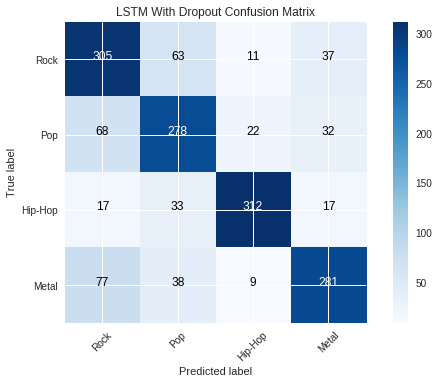

In [76]:
cnf_mtrx = confusion_matrix(y_vals, preds, labels=['Rock', 'Pop', 'Hip-Hop', 'Metal'])
plt.figure()
plot_confusion_matrix(cnf_mtrx, classes=['Rock', 'Pop', 'Hip-Hop', 'Metal'],
                      title='LSTM With Dropout Confusion Matrix')
plt.show()